In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display
from IPython.core.pylabtools import figsize
from __future__ import print_function

import os
import sys
import glob
import time
import numpy as np
import numpy.random as nr

from keras.preprocessing.image import load_img, img_to_array, array_to_img

from keras.models import Model
from keras.applications import vgg19

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b
from scipy.ndimage.filters import gaussian_filter

np.set_printoptions(precision=3, linewidth=120, suppress=True)

Using TensorFlow backend.


In [2]:
sys.path.append('../src')
from my_keras_utilities import get_available_gpus
import keras.backend as K
K.set_floatx('float32')

print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())

Backend:        tensorflow
Data format:    channels_last
Available GPUS: ['/gpu:0']


<table align='left'>
<tr><td colspan=2> <img src="https://docs.google.com/drawings/d/1IHznpizrL6uJl6r6-wDaUmCMHi6X4NU3nqP5Kg3Rtsw/pub?w=960&h=720"> </td></tr>
</table>


In [3]:
figdir = '../figures/style_transfer/'
resdir = figdir + 'results/'
os.makedirs(resdir, exist_ok=True)
image_file_path = figdir + 'museu_by_bruna.png'
style_file_path = figdir + 'tolouse-lautrec.png'

width, height = load_img(image_file_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(a):
    x = a.copy()
    x = x.reshape(img_nrows, img_ncols, 3)
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

print('Shape of the images: {} rows, {} columns'.format(img_nrows, img_ncols))

Shape of the images: 400 rows, 499 columns


(1, 400, 499, 3) -116.779 131.32


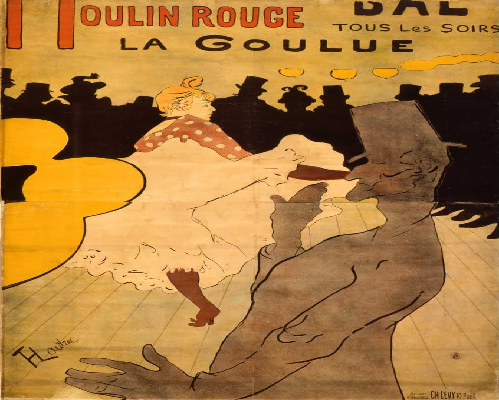

In [4]:
vgg_image = preprocess_image(image_file_path)
vgg_style = preprocess_image(style_file_path)

print(vgg_style.shape, vgg_style.min(), vgg_style.max())

array_to_img(deprocess_image(vgg_style[0]))

In [5]:
vgg = vgg19.VGG19(include_top=False, weights='imagenet', input_shape=vgg_image.shape[1:])
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 499, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 400, 499, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 499, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 249, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 249, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 249, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 124, 128)     0         
__________

In [6]:
def gram_matrix(x):
    # We want each row to be a channel, and the columns to be flattened x,y locations
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # The dot product of this with its transpose shows the correlation between each pair of channels
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

def compute_style_loss(output, target): 
    """this "style loss" is designed to maintain
    the style of the reference image in the generated image.
    It is based on the gram matrices (which capture style) of
    feature maps from the style reference image
    and from the generated image"""
    x_gram = gram_matrix(output)
    t_gram = gram_matrix(target)
    return K.mean(K.square(x_gram - t_gram))

def compute_content_loss(output, target):
    """this "content loss" function is
    designed to maintain the "content" of the
    base image in the generated image"""
    return K.sum(K.square(output - target)) / 2.0


class Evaluator(object):
    def __init__(self, fun, shp): 
        self.funct = fun
        self.shape = shp
        
    def get_loss(self, x):
        self.loss = self.funct([x.reshape(self.shape)])
        return self.loss.astype(np.float64)

    def get_grads(self, x): 
        return self.grad_values.flatten().astype(np.float64)

def my_solver(obj, niter, x, prefix=None):
    images = []
    try:
        for i in range(niter):
            t0 = time.time()
            x, min_val, info = fmin_l_bfgs_b(obj.get_loss, x.flatten(), fprime=obj.get_grads, maxfun=20)
            dt = time.time() - t0
            print('{:2d}. loss: {:.3f} {:.3f}s'.format(i, min_val, dt))
            if prefix is not None:
                imsave(resdir + prefix + '_at_iteration_{:02d}.png'.format(i), deprocess_image(x))
            images.append(x.copy())
    except KeyboardInterrupt:
        print('Interrupted!!')
    except:
        raise
    finally:
        return images  

In [ ]:
vgg_output_dict = {layer.name: layer.output for layer in vgg.layers}

In [7]:
style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]

style_outputs = [vgg_output_dict['block{}_conv1'.format(o)] for o in range(1,6)]
style_model = Model(vgg.input, style_outputs)
style_targets = [K.variable(o) for o in style_model.predict(vgg_style)]
style_loss = sum(w * compute_style_loss(out[0], targ[0]) for out, targ, w in zip(style_outputs, style_targets, style_weights))

In [8]:
grads = K.gradients(loss, vgg.input)
style_fn = K.function([vgg.input], [style_loss]+grads)

In [9]:
x = np.random.uniform(0.0, 255.0, vgg_image.shape) - 128.0

A = my_solver(Evaluator(style_fn, vgg_image.shape), 10, x)

 0. loss: 17340.816 12.552s
 1. loss: 6129.773 7.251s
 2. loss: 3296.612 7.321s
 3. loss: 2079.111 7.357s
 4. loss: 1587.780 7.248s
 5. loss: 1263.104 7.334s
 6. loss: 1053.542 7.356s
 7. loss: 914.008 7.423s
 8. loss: 812.841 7.337s
 9. loss: 724.409 7.404s


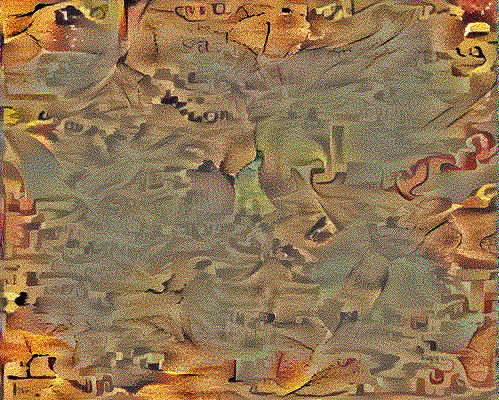

In [10]:
array_to_img(deprocess_image(A[-1]))